# Natural Language Processing with Transformers

## Chapter 6 - Summarization

- classic sequence to sequence task
- we use an encoder-decoder model

dataset used: CNN/DailyMail corpus - 300_000 pairs of news articles + summaries. **The summaries are abstractive not extractive** i.e. new sentences, not just excerpts from larger article.

Version 3.0.0 of dataset is NONANONYMIZED and used for summarization models



In [3]:
!pip install -U huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 6.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.22.2
    Uninstalling huggingface-hub-0.22.2:
      Successfully uninstalled huggingface-hub-0.22.2


In [5]:
!pip install -U datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 14.1 MB/s eta 0:00:0000:01
  Attempting uninstall: datasets
    Found existing installation: datasets 2.18.0
    Uninstalling datasets-2.18.0:
      Successfully uninstalled datasets-2.18.0


In [8]:
# See AyhamAlom comment on
# https://github.com/huggingface/datasets/issues/3465
# there is a backup version of dataset
# https://github.com/huggingface/datasets/issues/873

from datasets import load_dataset

dataset = load_dataset("ccdv/cnn_dailymail", version='3.0.0') # NEED TO DOWNLOAD DIFFERENT VERSION THAN IN HF BOOK

print(f"Features: {dataset['train'].column_names}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Features: ['article', 'highlights', 'id']


In [9]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 3192):

(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has n

Summary (length: 180):
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .


We see that the articles can be very long compared to the target summary; in this par‐
ticular case the difference is 17-fold. Long articles pose a challenge to most trans‐
former models since the context size is usually limited to 1,000 tokens or so, which is
equivalent to a few paragraphs of text. The standard, yet crude way to deal with this
for summarization is to simply truncate the texts beyond the model’s context size.
Obviously there could be important information for the summary toward the end of
the text, but for now we need to live with this limitation of the model architectures.

---

## Examples with text summary pipelines and different existing models

- here look at behavior/outputs from existing models
- take the same example for all models, and first 2000 chars of the paragraph (the above article on sprinters)

In [10]:
sample_text = dataset["train"][1]["article"][:2000]
# We'll collect the generated summaries of each model in a dictionary
summaries = {}

**IMPORTANT:**

A convention in summarization is to separate the summary sentences by a newline.
We could add a newline token after each full stop, but this simple heuristic would fail
for strings like “U.S.” or “U.N.” The Natural Language Toolkit (NLTK) package
includes a more sophisticated algorithm that can differentiate the end of a sentence
from punctuation that occurs in abbreviations:

In [12]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

string = "The U.S. are a country. The U.N. is an organization."

sent_tokenize(string)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization baseline - take first 3 sentences

This is standard practice / "Dummy Summary" kind of approach

In [13]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2, T5, BART, PEGASUS models now:

- for gpt-2, get summary by appending "TL;DR" to input
- for T5: **TODO: reread** talks about how it was trained on a variety of tasks, all formulated as text-to-text tasks; and all you do is prepend your data with an appropriate prompt e.g. `summarize:<ARTICLE>` or `translate English to German:<TEXT>`
- BART - **NOTE THAT WE ARE USING bart-large-cnn THAT HAS BEEN FINETUNED ON THIS DATASET ALREADY**
- PEGASUS: is a SOTA (2020) model for text summarization - pretraining is predict masked sentence in MULTISENTENCE tasks (**TODO: read paper / description**)

NOTE: PEGASUS has special token for newlines so you don't need the NLTK `sent_tokenize()` function

In [14]:
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline("text-generation", model="gpt2-xl")
gpt2_query = sample_text + "\nTL;DR:\n"

pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)

summaries["gpt2"] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

2024-05-12 16:39:20.336825: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 16:39:20.336958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 16:39:20.470686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


config.json:   0%|          | 0.00/689 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.43G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [18]:
pipe = pipeline("summarization", model="t5-large")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

In [19]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [20]:
#
# NOTE: PEGASUS has special token for newlines so you don't need the NLTK `sent_tokenize()` function
#

pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
pipe_out = pipe(sample_text)
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

## Overview of Summarization performance

Keep in mind that one model has not been trained on the dataset at all
(GPT-2), one model has been fine-tuned on this task among others (T5), and two
models have exclusively been fine-tuned on this task (BART and PEGASUS). 

In [21]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Usain Bolt wins third gold of world championship .
Anchors Jamaica to 4x100m relay victory .
Eighth gold at the championships for Bolt .
Jamaica double up in women's 4x100m relay .

BASELINE
(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.
The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds.
The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover.

GPT2
Bolt finished in style by winning the final sprint event in Moscow.
There is still a few sprint events to go before Friday's final but so far this final gold should stand as a world record.

T5
usain bolt wins his third gold medal of the world championships in the men's 4x100m relay .
the 26-year-old anchored Jamai

## Measuring the Quality of Generated Text

- by eye, all the above seem OK - PEGASUS subjectively looks the best to me

Need to develop metrics to do this systematically.

BLEU and ROUGE explanations:

### BLEU

- precision-based metric
- instead of looking at alignment of tokens, we look at words or n-grams (??? clear this up after reading)
- count the number of words in the generation that occur in the reference and divide it by length of reference

**important correction:** we clip to make sure the limit count is based on how many times the word ACTUALLY occurs in the reference.

example: sentence is "the cat is on the mat" . Prediction is "the the the the the the" -> then before clipping, we have 6 correct predictions / length 6 = precision 100%. After clipping we have 2 correct predictions.

- there is then some further modifications:

You do a `prec_n` for all possible n-grams of degree n, and use the above clipping in all cases

Also:

Since we are not looking at recall, all generated sequences that are
short but precise have a benefit compared to sentences that are longer. Therefore, the
precision score favors short generations. To compensate for that the authors of BLEU
introduced an additional term, the brevity penalty

**here a formula which just has length as an exponent - simple**

People report the BLEU-N score where N is "we use n-grams up to N"

---

However, you can probably already see
that this metric has many limitations; for instance, it doesn’t take synonyms into
account, and many steps in the derivation seem like ad hoc and rather fragile heuristics. You can find a wonderful exposition of BLEU’s flaws in Rachel Tatman’s blog
post “Evaluating Text Output in NLP: BLEU at Your Own Risk”.

In general, the field of text generation is still looking for better evaluation metrics,
and finding ways to overcome the limits of metrics like BLEU is an active area of
research. Another weakness of the BLEU metric is that it expects the text to already
be tokenized. This can lead to varying results if the exact same method for text toke‐
nization is not used. The SacreBLEU metric addresses this issue by internalizing the
tokenization step; for this reason, it is the preferred metric for benchmarking.


---

Using metrics from datasets library:

In [25]:
!pip install evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00


In [27]:
!pip install sacrebleu

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 7.2 MB/s eta 0:00:00


In [28]:
#from datasets import load_metric
#
# NOTE BOOK CODE IS DEPRECATED - HAVE TO USE EVALUATE INSTEAD NOW
#

import evaluate

bleu_metric = evaluate.load("sacrebleu")

The bleu_metric object is an instance of the Metric class, and works like an aggregator: you can add single instances with add() or whole batches via add_batch(). Once
you have added all the samples you need to evaluate, you then call compute() and the
metric is calculated. This returns a dictionary with several values, such as the precision for each n-gram, the length penalty, as well as the final BLEU score. Let’s look at
the example from before:

In [29]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction="the the the the the the", reference=["the cat is on the mat"])

results = bleu_metric.compute(smooth_method="floor", smooth_value=0)

results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


**INTERPRETATION - THE ABOVE 4 VALUES ARE FOR n=1,2,3,4 n-GRAMS**

In [30]:
bleu_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])

results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]
pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


## ROUGE

The BLEU score is widely used for evaluating text, especially in machine translation,
since precise translations are usually favored over translations that include all possible
and appropriate words.

There are other applications, such as summarization, where the situation is different.
There, we want all the important information in the generated text, so we favor high
recall. This is where the ROUGE score is usually used.

The ROUGE score was specifically developed for applications like summarization
where high recall is more important than just precision

The approach is very similar
to the BLEU score in that we look at different n-grams and compare their occurrences
in the generated text and the reference texts. The difference is that with ROUGE we
check how many n-grams in the reference text also occur in the generated text. For
BLEU we looked at how many n-grams in the generated text appear in the reference,
so we can reuse the precision formula with the minor modification that we count the
(unclipped) occurrence of reference n-grams in the generated text in the numerator

This was the original proposal for ROUGE. Subsequently, researchers have found that
fully removing precision can have strong negative effects. Going back to the BLEU
formula without the clipped counting, we can measure precision as well, and we can
then combine both precision and recall ROUGE scores in the harmonic mean to get
an F1-score. This score is the metric that is nowadays commonly reported for
ROUGE.

**TODO: read about the differences between the different variations of ROUGE (see results below)**

In [32]:
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=abbdd31a571d549c90b0c9b297db2656b127418f4cd8389cebab8ed78d119cb2
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [33]:
rouge_metric = evaluate.load("rouge")

### Apply ROUGE score to the summaries created by the various models earlier

**NOTE: therefore that here the `reference` is the gold standard summary from the dataset**

In [36]:
reference = dataset["train"][1]["highlights"]

records = []

# TODO: understand the differences between these methods
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    
    # NOTE DEPRECATED CODE IN BOOK
    # https://stackoverflow.com/questions/73826120/numpy-float64-object-has-no-attribute-mid
    # GET THE ERROR:
    # AttributeError: 'numpy.float64' object has no attribute 'mid'
    # ITS FROM OLD HF IMPLEMENTATION - JUST DROP THE .mid.fmeasure STUFF AS IN THE STACKOVERFLOW POST O_o
    #
    #rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    rouge_dict = dict((rn, score[rn]) for rn in rouge_names)
    
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.303571,0.090909,0.214286,0.232143
gpt2,0.212121,0.000000,0.121212,0.212121
t5,0.486486,0.222222,0.378378,0.486486
bart,0.582278,0.207792,0.455696,0.506329
pegasus,0.866667,0.655172,0.800000,0.833333


# Evaluating PEGASUS on the CNN DailyMail dataset

- code for the 3 sentence dummy summary baseline:

In [37]:
def evaluate_summaries_baseline(dataset, metric, column_text="article",column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

**Test dataset split is 10k setences - too large: use 50 instead**

HF BOOK USES 1k SAMPLES FOR 1 HOUR OF GPU O_o i noticed, so just used 50 - don't care about the results just wanted to see behaviour

In [38]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(50))

score = evaluate_summaries_baseline(test_sampled, rouge_metric)

#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.408768,0.198378,0.271183,0.380515


**Now implement evaluation func for PEGASUS model:**

In [39]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]
        
        
def evaluate_summaries_pegasus(dataset, metric, model, tokenizer, batch_size=16, device=device,column_text="article",column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True,padding="max_length", return_tensors="pt")
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),attention_mask=inputs["attention_mask"].to(device),length_penalty=0.8, num_beams=8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,clean_up_tokenization_spaces=True) for s in summaries]
        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]
    metric.add_batch(predictions=decoded_summaries, references=target_batch)
    score = metric.compute()
    return score

Let’s unpack this evaluation code a bit. First we split the dataset into smaller batches
that we can process simultaneously. Then for each batch we tokenize the input articles and feed them to the generate() function to produce the summaries using beam
search. We use the same generation parameters as proposed in the paper. The new
parameter for length penalty ensures that the model does not generate sequences that
are too long. Finally, we decode the generated texts, replace the <n> token, and add
the decoded texts with the references to the metric. At the end, we compute and
return the ROUGE scores. Let’s now load the model again with the AutoModelFor
Seq2SeqLM class, used for seq2seq generation tasks, and evaluate it:

In [41]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)
score = evaluate_summaries_pegasus(test_sampled, rouge_metric, model, tokenizer, batch_size=8)

#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 7/7 [00:49<00:00,  7.08s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.518118,0.284161,0.31865,0.439328


**NOTE/reminder - i only did 50 samples instead of 1k or even 10k from the test dataset so scores above aren't to be taken too seriously**

book has 0.43/.21/.30/.37 so not too far from the above scores

---

# Training a Summarization Model

We now use the `SAMSum` dataset (from Samsung - collection of dialogues + summaries of them)

In [42]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split])for split in dataset_samsum]


print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")

print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


**note: the (placeholder) gifs and emojis- it's meant to be a whatsapp conversation**

---

## First - evaluate PEGASUS baseline on SAMSum

- remember that PEGASUS has been trained on CNN/DailyMail for summarization; here we have a chat-based format so might not work correctly:



In [43]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print(pipe_out[0]["summary_text"].replace(" .<n>", ".\n"))

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Summary:
Amanda: Ask Larry Amanda: He called her last time we were at the park together.
Hannah: I'd rather you texted him.
Amanda: Just text him .


We can see that the model mostly tries to summarize by extracting the key sentences
from the dialogue. This probably worked relatively well on the CNN/DailyMail data‐
set, but the summaries in SAMSum are more abstract. 

**Let’s confirm this by running the full ROUGE evaluation on the test set:**

In [44]:
score = evaluate_summaries_pegasus(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)

#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["pegasus"])

100%|██████████| 103/103 [12:25<00:00,  7.23s/it]


AttributeError: 'numpy.float64' object has no attribute 'mid'

**NOTE: i ran it for 15mins only to get the AttributeError: 'numpy.float64' object has no attribute 'mid'**

**NEED TO REPLACE: rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)**

and then rerun - not important though so skipped for now.

Well, the results aren’t great, but this is not unexpected since we’ve moved quite a bit away from the CNN/DailyMail data distribution

---

## Finetuning PEGASUS

- look at stats/distribution of dataset

In [46]:
from matplotlib import pyplot as plt

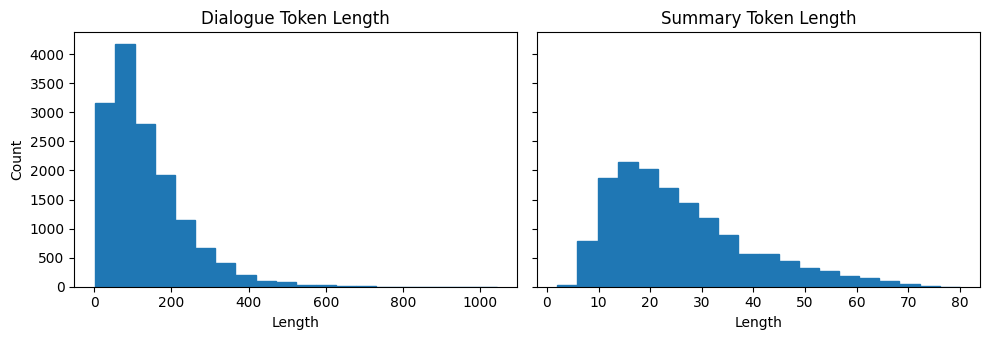

In [47]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)

axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")

plt.tight_layout()
plt.show()

We see that most dialogues are much shorter than the CNN/DailyMail articles, with
100–200 tokens per dialogue. Similarly, the summaries are much shorter, with around
20–40 tokens (the average length of a tweet).

Let’s keep those observations in mind as we build the data collator for the Trainer.
First we need to tokenize the dataset. For now, we’ll set the maximum lengths to 1024
and 128 for the dialogues and summaries, respectively

In [48]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,truncation=True)
    return {"input_ids": input_encodings["input_ids"], "attention_mask": input_encodings["attention_mask"], "labels": target_encodings["input_ids"]}

### tokenizer for decoder inputs and special tokens

**IMPORTANT: new when working with encoder - decoder stuff:**

A new thing in the use of the tokenization step is the `tokenizer.as_target_tokenizer()` context. Some models require special tokens in the decoder inputs, so it’s
important to differentiate between the tokenization of encoder and decoder inputs. In
the with statement (called a context manager), the tokenizer knows that it is tokenizing for the decoder and can process sequences accordingly.

In [49]:
dataset_samsum["train"][0]

{'id': '13818513',
 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)",
 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}

In [50]:
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:3935: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

## Data Collator for Seq2Seq 

**TODO: reread this, quite unclear for now**

Now, we need to create the data collator. This function is called in the Trainer just
before the batch is fed through the model. In most cases we can use the default collator, which collects all the tensors from the batch and simply stacks them. For the
summarization task we need to not only stack the inputs but also prepare the targets
on the decoder side. PEGASUS is an encoder-decoder transformer and thus has the
classic seq2seq architecture. In a seq2seq setup, a common approach is to apply
“teacher forcing” in the decoder. With this strategy, the decoder receives input tokens
(like in decoder-only models such as GPT-2) that consists of the labels shifted by one
in addition to the encoder output; so, when making the prediction for the next token
the decoder gets the ground truth shifted by one as an input, as illustrated in the following table:

decoder_input label

step

1 [PAD] Transformers

2 [PAD, Transformers] are

3 [PAD, Transformers, are] awesome

4 [PAD, Transformers, are, awesome] for

5 [PAD, Transformers, are, awesome, for] text

6 [PAD, Transformers, are, awesome, for, text] summarization


We shift it by one so that the decoder only sees the previous ground truth labels and
not the current or future ones. Shifting alone suffices since the decoder has masked
self-attention that masks all inputs at present and in the future.

So, when we prepare our batch, we set up the decoder inputs by shifting the labels to
the right by one. After that, we make sure the padding tokens in the labels are ignored
by the loss function by setting them to –100. We actually don’t have to do this man‐
ually, though, since the DataCollatorForSeq2Seq comes to the rescue and takes care
of all these steps for us:

In [51]:
from transformers import DataCollatorForSeq2Seq

seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [52]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='pegasus-samsum-nlp-with-transformers-ch06',
    num_train_epochs=1,
    warmup_steps=500,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    weight_decay=0.01,
    logging_steps=10,
    push_to_hub=True,
    evaluation_strategy='steps',
    eval_steps=500,
    save_steps=1e6,
    gradient_accumulation_steps=16,
    report_to="none",
)

**Note: first time using gradient accumulation**

Since model is big we set batchsize = 1.

But small batch sizes can hurt convergence of model.

So we use Gradient Accumulation (note: the explanation in book is really unclear: 

As the name suggests, instead of calculating *the gradients of the full batch all at once* (**I think what they mean here is "instead of calculating the gradients of a VERY LARGE BATCH"**), we make smaller
batches and aggregate the gradients. When we have aggregated enough gradients, we
run the optimization step. Naturally this is a bit slower than doing it in one pass, but
it saves us a lot of GPU memory.

In [53]:
# will save to HF O_o might reuse model later

from huggingface_hub import notebook_login

notebook_login()

In [54]:
trainer = Trainer(model=model,
                  args=training_args,
                  tokenizer=tokenizer,
                  data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"],
                 )

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [55]:
# -- TRAINING --
trainer.train()


Step,Training Loss,Validation Loss
500,1.659200,1.483876


TrainOutput(global_step=920, training_loss=1.8168589343195376, metrics={'train_runtime': 2077.4559, 'train_samples_per_second': 7.091, 'train_steps_per_second': 0.443, 'total_flos': 5528248038285312.0, 'train_loss': 1.8168589343195376, 'epoch': 1.0})

## NOTE - trainer.model below

I had not seen that before - I was wondering about this when figuring out the `trainer.predict()` stuff : maybe this is better way of "getting the model" if you have the trainer already loaded??

Lots of this stuff is so underdocumented O_o

In [56]:
# -- EVALUATION ON TEST SET --
score = evaluate_summaries_pegasus(dataset_samsum["test"],
                                   rouge_metric,
                                   trainer.model,
                                   tokenizer,
                                   batch_size=2,
                                   column_text="dialogue",
                                   column_summary="summary")

#rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
rouge_dict = dict((rn, score[rn]) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=[f"pegasus"])

100%|██████████| 410/410 [09:26<00:00,  1.38s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.555556,0.230769,0.518519,0.518519


For some reason the scores here are much better than ones in book O_o maybe optimizations since 2020 of the seq2seq automodels ??

---

## Note on generative models p162 book

You can also evaluate the generations as part of the training loop:
use the extension of TrainingArguments called Seq2SeqTraining
Arguments and specify predict_with_generate=True. Pass it to
the dedicated Trainer called Seq2SeqTrainer, which then uses the
generate() function instead of the model’s forward pass to create
predictions for evaluation. 

In [57]:
trainer.push_to_hub("Finetune PEGASUS on SAMSum dataset - ch06 Summarization of NLP With Transformers book")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 32, 'num_beams': 8, 'length_penalty': 0.8, 'forced_eos_token_id': 1}


spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/benjaminzwhite/pegasus-samsum-nlp-with-transformers-ch06/commit/82da0b593be7601d616b78b7de9de18d69bb4d06', commit_message='Finetune PEGASUS on SAMSum dataset - ch06 Summarization of NLP With Transformers book', commit_description='', oid='82da0b593be7601d616b78b7de9de18d69bb4d06', pr_url=None, pr_revision=None, pr_num=None)

## Using finetuned model and generating summaries

Generate a summary from the test set to see quality:

In [58]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}
sample_text = dataset_samsum["test"][0]["dialogue"]
reference = dataset_samsum["test"][0]["summary"]
pipe = pipeline("summarization", model="transformersbook/pegasus-samsum")

print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.


Above is with the checkpoint from the book - same below but with my personal saved checkpoint:

In [59]:
# -- note : using my checkpoint --

pipe = pipeline("summarization", model="benjaminzwhite/pegasus-samsum-nlp-with-transformers-ch06")

print("Dialogue:")
print(sample_text)

print("\nReference Summary:")
print(reference)

print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

config.json:   0%|          | 0.00/1.32k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/275 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/6.60M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.77k [00:00<?, ?B/s]

Your max_length is set to 128, but your input_length is only 122. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=61)


Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.


Just for reference the side by side:

- (HF book checkpoint) Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry instead of calling Betty.
- (my checkpoint) Amanda can't find Betty's number. Larry called Betty last time they were at the park together. Hannah wants Amanda to text Larry. Amanda will text Larry.

2nd seems worse : it is NOT Amanda who will text Larry, but Hannah

---

### test on custom sample from book

In [60]:
custom_dialogue = """\
Thom: Hi guys, have you heard of transformers?
Lewis: Yes, I used them recently!
Leandro: Indeed, there is a great library by Hugging Face.
Thom: I know, I helped build it ;)
Lewis: Cool, maybe we should write a book about it. What do you think?
Leandro: Great idea, how hard can it be?!
Thom: I am in!
Lewis: Awesome, let's do it together!
"""
print(pipe(custom_dialogue, **gen_kwargs)[0]["summary_text"])

Your max_length is set to 128, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)


Thom, Lewis, Leandro and Leandro are going to write a book about transformers and Hugging Face. Thom is in for it, Lewis and Leandro are in for it.


**compare the above (my checkpoint) to HF book one:**

Thom, Lewis and Leandro are going to write a book about transformers. Thom
helped build a library by Hugging Face. They are going to do it together.

IMHO theirs seems better again on this

---

# End of chapter and conclusion

Text summarization poses some unique challenges compared to other tasks that can
be framed as classification tasks, like sentiment analysis, named entity recognition, or
question answering. Conventional metrics such as accuracy do not reflect the quality
of the generated text. As we saw, the BLEU and ROUGE metrics can better evaluate
generated texts; however, human judgment remains the best measure.

A common question when working with summarization models is how we can summarize documents where the texts are longer than the model’s context length.

Unfortunately, there is no single strategy to solve this problem, and to date this is still
an open and active research question. For example, recent work (NOTE BOOK IS 2020) by OpenAI showed
how to scale summarization by applying it recursively to long documents and using
human feedback in the loop